In [15]:
# import pyspark modules
import os
from pyspark import SparkContext
from pyspark.sql import SQLContext
from pyspark.sql import Row
from pyspark.sql import types as typ     # for datatype conversion
from pyspark.sql import functions as F  # for col() function
from pyspark.ml.linalg import DenseVector
from pyspark.ml.feature import StandardScaler
from pyspark.ml.regression import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sc = SparkContext.getOrCreate()
sqlCtx = SQLContext(sc)

# Data Import and Preprocessing

## Imputing, Bining and Filtering

In [16]:
suicide = pd.read_csv ('master.csv')

In [17]:
suicide.head()

,country,year,sex,age,suicides_no,population,suicides/100k pop,country-year,HDI for year,gdp_for_year ($),gdp_per_capita ($),generation
0,Albania,1987,male,15-24 years,21,312900,6.71,Albania1987,NaN,"2,156,624,900",796,Generation X
1,Albania,1987,male,35-54 years,16,308000,5.19,Albania1987,NaN,"2,156,624,900",796,Silent
2,Albania,1987,female,15-24 years,14,289700,4.83,Albania1987,NaN,"2,156,624,900",796,Generation X
3,Albania,1987,male,75+ years,1,21800,4.59,Albania1987,NaN,"2,156,624,900",796,G.I. Generation
4,Albania,1987,male,25-34 years,9,274300,3.28,Albania1987,NaN,"2,156,624,900",796,Boomers


In [18]:
df = sqlCtx.createDataFrame(suicide)

In [19]:
df.show(5)

+-------+----+------+-----------+-----------+----------+-----------------+------------+------------+------------------+------------------+---------------+
|country|year|   sex|        age|suicides_no|population|suicides/100k pop|country-year|HDI for year| gdp_for_year ($) |gdp_per_capita ($)|     generation|
+-------+----+------+-----------+-----------+----------+-----------------+------------+------------+------------------+------------------+---------------+
|Albania|1987|  male|15-24 years|         21|    312900|             6.71| Albania1987|         NaN|     2,156,624,900|               796|   Generation X|
|Albania|1987|  male|35-54 years|         16|    308000|             5.19| Albania1987|         NaN|     2,156,624,900|               796|         Silent|
|Albania|1987|female|15-24 years|         14|    289700|             4.83| Albania1987|         NaN|     2,156,624,900|               796|   Generation X|
|Albania|1987|  male|  75+ years|          1|     21800|             4

In [20]:
df.count()

27820

In [21]:
df.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: long (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: long (nullable = true)
 |-- population: long (nullable = true)
 |-- suicides/100k pop: double (nullable = true)
 |-- country-year: string (nullable = true)
 |-- HDI for year: double (nullable = true)
 |--  gdp_for_year ($) : string (nullable = true)
 |-- gdp_per_capita ($): long (nullable = true)
 |-- generation: string (nullable = true)



In [60]:
df.select(['age','year','suicides/100k pop']).show(5)

+-----------+----+-----------------+
|        age|year|suicides/100k pop|
+-----------+----+-----------------+
|15-24 years|1987|             6.71|
|35-54 years|1987|             5.19|
|15-24 years|1987|             4.83|
|  75+ years|1987|             4.59|
|25-34 years|1987|             3.28|
+-----------+----+-----------------+
only showing top 5 rows



In [22]:
df.cache()

DataFrame[country: string, year: bigint, sex: string, age: string, suicides_no: bigint, population: bigint, suicides/100k pop: double, country-year: string, HDI for year: double,  gdp_for_year ($) : string, gdp_per_capita ($): bigint, generation: string]

In [23]:
#Describe major attributions
df.describe(['suicides_no','population','suicides/100k pop', 'gdp_per_capita ($)',' gdp_for_year ($) ']).show()
    #suicide/100k pop is optimal than suicides_no
    #problem with the data type of gdp_for_year

+-------+------------------+------------------+------------------+------------------+------------------+
|summary|       suicides_no|        population| suicides/100k pop|gdp_per_capita ($)| gdp_for_year ($) |
+-------+------------------+------------------+------------------+------------------+------------------+
|  count|             27820|             27820|             27820|             27820|             27820|
|   mean|242.57440690150972|1844793.6173975556|12.816097411933846|16866.464414090584|              null|
| stddev| 902.0479168336386|3911779.4417563654|18.961511014503152|18887.576472205557|              null|
|    min|                 0|               278|               0.0|               251| 1,002,219,052,968|
|    max|             22338|          43805214|            224.97|            126352|       997,007,926|
+-------+------------------+------------------+------------------+------------------+------------------+



In [24]:
#compute correlation
df.corr('suicides/100k pop','gdp_per_capita ($)')

0.0017851337973438972

In [25]:
# compute correlation between all numeric features
features_numeric = ['suicides_no','population','suicides/100k pop', 'gdp_per_capita ($)']

n_numeric = len(features_numeric)
corr = []

for i in range(0, n_numeric):
 temp = [None] * i

 for j in range(i, n_numeric):
     temp.append(df.corr(features_numeric[i], features_numeric[j]))
 corr.append(temp)

In [26]:
corr
   #suicides_no and population

[[1.0, 0.6161622675219296, 0.3066044512677847, 0.06132974884024606],
 [None, 1.0, 0.008284973053478351, 0.08150985822280572],
 [None, None, 1.0, 0.0017851337973438972],
 [None, None, None, 1.0]]

In [27]:
#rename in case of name sensitivity
df = df.withColumnRenamed("suicides/100k pop", "suicide_100k_pop") \
.withColumnRenamed("gdp_per_capita ($)", "gdp_per_capita")

In [28]:
df.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: long (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: long (nullable = true)
 |-- population: long (nullable = true)
 |-- suicide_100k_pop: double (nullable = true)
 |-- country-year: string (nullable = true)
 |-- HDI for year: double (nullable = true)
 |--  gdp_for_year ($) : string (nullable = true)
 |-- gdp_per_capita: long (nullable = true)
 |-- generation: string (nullable = true)



## feature engineering

In [29]:
import pyspark.mllib.stat as st
import numpy as np
from pyspark.sql.functions import col, asc

In [30]:
#feature transform: grouping countries into regions
Africa = ["Algeria", "Angola", "Benin", "Botswana", "Burkina Faso", "Burundi", "Cameroon","Cabo Verde", "Cape Verde",
          "Central African Republic", "Chad", "Comoros", "Côte d’Ivoire", "Democratic Republic of the Congo",
          "Equatorial Guinea", "Eritrea", "Ethiopia", "Gabon", "Gambia", "Ghana", "Guinea", "Guinea-Bissau",
          "Kenya", "Lesotho", "Liberia", "Madagascar", "Malawi", "Mali", "Mauritania", "Mauritius", "Mozambique",
          "Namibia", "Niger", "Nigeria", "Republic of the Congo", "Rwanda", "Sao Tome and Principe", "Senegal", 
          "Seychelles", "Sierra Leone", "South Africa", "Swaziland", "Togo", "Uganda", "United Republic of Tanzania",
          "Zambia", "Zimbabwe"]
Americas = ["Antigua and Barbuda", "Aruba","Argentina", "Bahamas", "Barbados", "Belize", "Bolivia (Plurinational State of)", 
            "Brazil", "Canada", "Chile", "Colombia", "Costa Rica", "Cuba", "Dominica", "Dominican Republic", "Ecuador",
            "El Salvador", "Grenada", "Guatemala", "Guyana", "Haiti", "Honduras", "Jamaica", "Mexico", "Nicaragua", "Panama",
            "Paraguay", "Peru","Puerto Rico", "Saint Kitts and Nevis", "Saint Lucia", "Saint Vincent and Grenadines", "Suriname", 
            "Trinidad and Tobago", "United States", "Uruguay", "Venezuela (Bolivarian Republic of)"]
SouthEastAsia = ["Bangladesh", "Bhutan", "Democratic People’s Republic of Korea", "India", "Indonesia", "Maldives", "Myanmar",
                 "Nepal", "Sri Lanka", "Thailand", "Timor-Leste"]
European = ["Albania", "Andorra", "Armenia", "Austria", "Azerbaijan", "Belarus", "Belgium", "Bosnia and Herzegovina", "Bulgaria",
            "Croatia", "Cyprus", "Czech Republic", "Denmark", "Estonia", "Finland", "France", "Georgia", "Germany", "Greece", 
            "Hungary", "Iceland", "Ireland", "Israel", "Italy", "Kazakhstan", "Kyrgyzstan", "Latvia", "Lithuania", "Luxembourg",
            "Malta", "Monaco", "Montenegro", "Netherlands", "Norway", "Poland", "Portugal", "Republic of Moldova", "Romania",
            "Russian Federation", "San Marino", "Serbia", "Slovakia", "Slovenia", "Spain", "Sweden", "Switzerland", "Tajikistan",
            "The former Yugoslav Republic of Macedonia", "Turkey", "Turkmenistan", "Ukraine", "United Kingdom", "Uzbekistan"]
EasternMediterranean = ["Afghanistan", "Bahrain", "Djibouti", "Egypt", "Iran (Islamic Republic of)", "Iraq", "Jordan", 
                        "Kuwait", "Lebanon", "Libyan Arab Jamahiriya", "Morocco", "Oman", "Pakistan", "Qatar", "Saudi Arabia",
                        "Somalia", "Sudan", "Syrian Arab Republic", "Tunisia", "United Arab Emirates", "Yemen"]
WesternPacific = ["Australia", "Brunei Darussalam", "Cambodia", "China", "Cook Islands", "Fiji", "Japan", "Kiribati", 
                  "Lao People’s Democratic Republic", "Malaysia", "Marshall Islands", "Micronesia (Federated States of)", 
                  "Mongolia", "Nauru", "New Zealand", "Niue", "Palau", "Papua New Guinea", "Philippines", "Republic of Korea",
                  "Samoa", "Singapore", "Solomon Islands", "Taiwan", "Tonga", "Tuvalu", "Vanuatu", "Vietnam","Macau"]

In [31]:
#filteredDF = df.filter(col("age") == "35-54 years").sort(asc("year"))

In [32]:
transformedDF = df.withColumn('region', F.when(F.col('country').isin(Africa), 'Africa')\
.when(F.col('country').isin(Americas), 'Americas') \
.when(F.col('country').isin(SouthEastAsia), 'SouthEastAsia')\
.when(F.col('country').isin(European), 'European')\
.when(F.col('country').isin(WesternPacific ), 'WesternPacific ')\
.when(F.col('country').isin(EasternMediterranean), 'EasternMediterranean'))                                                    

In [33]:
transformedDF2 = transformedDF.withColumn('year_span', F.when(((F.col("year")>=1985) & (F.col('year')<= 1988)),'1985-1988')\
.when(((F.col("year")>=1989) & (F.col('year')<= 1992)),'1989-1992')\
.when(((F.col('year')>=1993) & (F.col('year')<=1996)), '1993-1996')\
.when(((F.col('year')>=1997) & (F.col('year')<=2000)), '1997-2000')\
.when(((F.col('year')>=2001) & (F.col('year')<=2004)), '2001-2004')\
.when(((F.col('year')>=2005) & (F.col('year')<=2008)), '2005-2008')\
.when(((F.col('year')>=2009) & (F.col('year')<=2012)), '2009-2012')\
.when(((F.col('year')>=2013) & (F.col('year')<=2016)), '2013-2016'))
                                                                                    

In [34]:
df_processed = transformedDF2.withColumn("age_encoded", F.when(col("age")=='5-14 years', 0)
                                         .when(col("age")=='15-24 years', 1)
                                         .when(col("age")=='25-34 years', 2)
                                         .when(col("age")=='35-54 years', 3)
                                         .when(col("age")=='55-74 years', 4)
                                         .when(col("age")=='75+ years', 5))

In [35]:
df_processed = df_processed.withColumn("sex_encoded", F.when(col("sex")=='female', 0)
                                         .when(col("sex")=='male', 1))

In [36]:
df_processed.printSchema()

root
 |-- country: string (nullable = true)
 |-- year: long (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: string (nullable = true)
 |-- suicides_no: long (nullable = true)
 |-- population: long (nullable = true)
 |-- suicide_100k_pop: double (nullable = true)
 |-- country-year: string (nullable = true)
 |-- HDI for year: double (nullable = true)
 |--  gdp_for_year ($) : string (nullable = true)
 |-- gdp_per_capita: long (nullable = true)
 |-- generation: string (nullable = true)
 |-- region: string (nullable = true)
 |-- year_span: string (nullable = true)
 |-- age_encoded: integer (nullable = true)
 |-- sex_encoded: integer (nullable = true)



## feature scaling

In [38]:
df_trimmed = df_processed.select(["region",
                "year_span",
                "sex_encoded",
                "age_encoded",
                "suicide_100k_pop",                              
                "gdp_per_capita",
                "population",
                "generation"])

In [39]:
df_trimmed.printSchema()

root
 |-- region: string (nullable = true)
 |-- year_span: string (nullable = true)
 |-- sex_encoded: integer (nullable = true)
 |-- age_encoded: integer (nullable = true)
 |-- suicide_100k_pop: double (nullable = true)
 |-- gdp_per_capita: long (nullable = true)
 |-- population: long (nullable = true)
 |-- generation: string (nullable = true)



# Exploratory data analysis

In [55]:
#age group for the year span from xxxx to xxxx  -carrie
#world map heat map by year (compare)    -leyi
#group by age group and select a specific country to get a trend plot \time and population  -bryan
#correlation heatmap

## Visualization

### Visualization 1

In [56]:
#world map heat map by year (compare)    -leyi

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

In [59]:
#plt.figure(figsize=(14,6))
#df_trimmed.groupby('region').sum().plot(kind='bar',figsize=(16,8),title='Suicide Based in Regions')

#plt.bar(temp['region'], temp["suicide_100k_pop"], width=2000)
#plt.title('Suicide Based in Regions')

AnalysisException: 'Cannot resolve column name "suicide_100k_pop" among (region, sum(sex_encoded), sum(age_encoded), sum(suicide_100k_pop), sum(gdp_per_capita));'

In [ ]:
#p = pd.crosstab(index=df_trimmed.region,columns=df_trimmed.year_span,values=df.suicides_no,aggfunc='sum')

#sns.heatmap(p.loc[:,2011:2015].sort_values(2015, ascending=False).dropna().head(5),annot=True)

#pp = pd.crosstab(index=df.country,columns=df.year,values=df.population,aggfunc='sum')

#pdivpp = p/pp*10000

### Visualization 2

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'StringIndexer' object has no attribute '_java_obj'
Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'IndexToString' object has no attribute '_java_obj'


Text(0.5,1,'Suicides for all age groups')

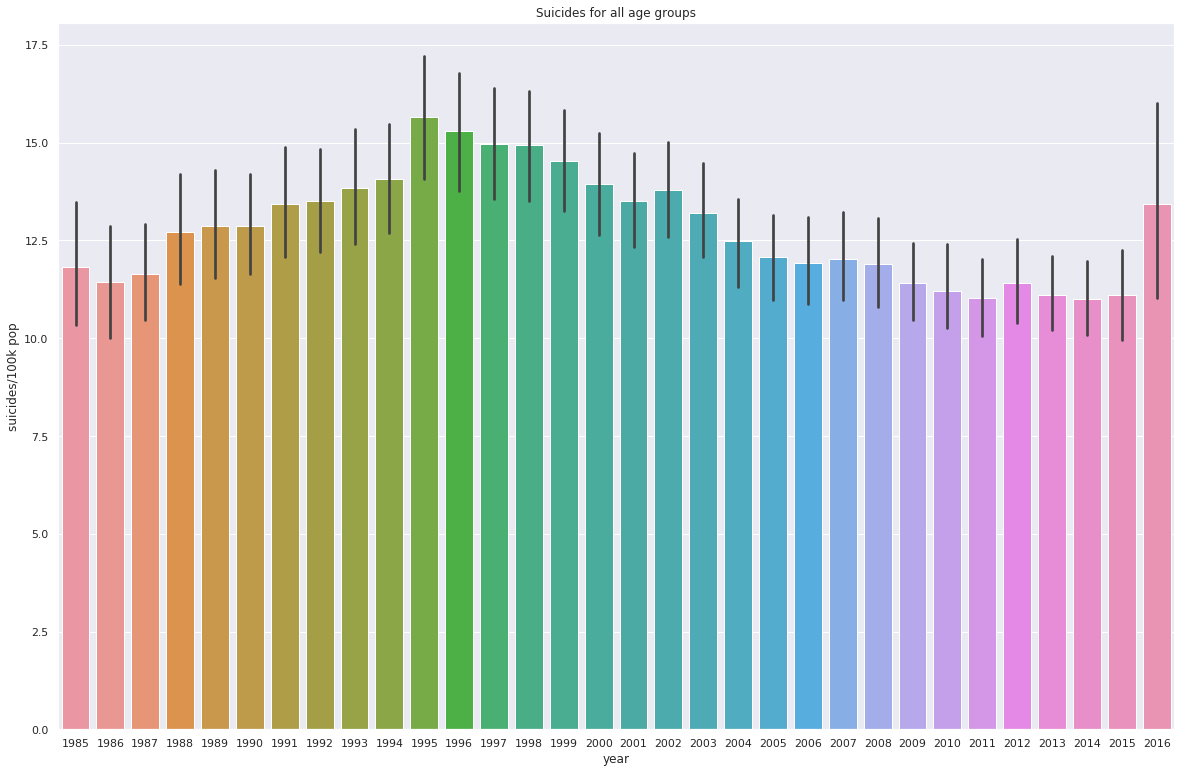

In [133]:
sns.set(rc={'figure.figsize':(20,13)})
ax = sns.barplot(x="year", y="suicides/100k pop",data=suicide)
ax.set_title('Suicides for all age groups')

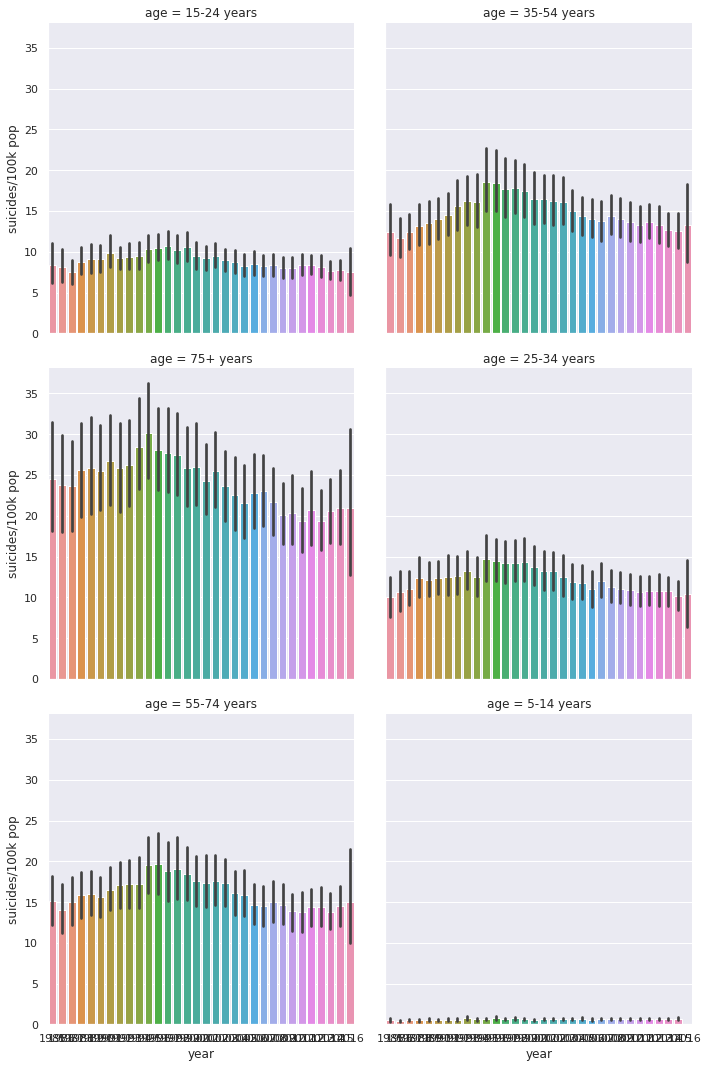

In [135]:
sns.catplot('year','suicides/100k pop',col='age',data=suicide,kind='bar',col_wrap=2)
sns.set(rc={'figure.figsize':(30,13)})

### Visualization 3

# Model Construction

## Data splitting

In [40]:
train_data, test_data = df_trimmed.randomSplit([0.8, 0.2], seed=123)

In [41]:
train_data, test_data.cache()

(DataFrame[region: string, year_span: string, sex_encoded: int, age_encoded: int, suicide_100k_pop: double, gdp_per_capita: bigint, population: bigint, generation: string],
 DataFrame[region: string, year_span: string, sex_encoded: int, age_encoded: int, suicide_100k_pop: double, gdp_per_capita: bigint, population: bigint, generation: string])

### Main Research Question:

data splitting: 
train 0.8
test 0.2

model building:

Random Forests (level of significance) --leyi
Logistic Regression (without regularization) --carrie
Lasso and Ridge Regression


model checking:
k-fold cross validation
for regression: MSE
R-square, adjusted R-square
for classification (accuracy, precision, confusion matrix)

what we found:
(answer research question)

Research Questions:

We will construct a model to predict the future suicide rate on the scale of per 100k population given the age group of 55-74 for the six WHO world regions in the next 3-year span.

## Supervised Learning--- Random Forest

### 1. Random Forest Implementation
#### evaluate the high risk groups for suicide and identify or discriminate high-risk subjects

In [66]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import VectorIndexer, StringIndexer, IndexToString
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [90]:
#RFmodel = RandomForest.trainRegressor(train_data, catgoricalFeaturesInfo= {}, numTrees= 1000, featureSubsetStrategy='auto', \
                                      impurity='variance', maxDepth= 4, maxBins =32)

NameError: name 'RandomForest' is not defined

In [91]:
#fit the dataset to include all labels in index
#labelIndexer = StringIndexer(inputCol='label', outputCol='indexedFeatures', maxCategories= 4).fit(transformedDF_trimmed)

TypeError: __init__() got an unexpected keyword argument 'maxCategories'

In [92]:
#identify categorical features and index them
#featureIndexer = VectorIndexer(inputCol='features', outputCol='indexedFeatures', maxCategories= 4).fit(transformedDF_trimmed)

NameError: name 'transformedDF_trimmed' is not defined

In [95]:
#train a random forest model
RFmodel = RandomForestClassifier(labelCol='indexedLabel', outputCol='indexedFeatures', numTrees=10)

TypeError: __init__() got an unexpected keyword argument 'outputCol'

In [96]:
#Convert indexed labels back to original labels
labelConverter = IndexToString(inputCol='features', outputCol='indexedFeatures', maxCategories= 4)

TypeError: __init__() got an unexpected keyword argument 'maxCategories'

In [97]:
#Chain indexers and forest in a pipeline
pipeline = Pipeline

### 2. Logistic Regression without regularization

In [104]:
import os
import pyspark.sql.types as typ
import pyspark.sql.functions as F
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .master("local") \
    .appName("data preprocessing") \
    .config("spark.executor.memory", '8g') \
    .config('spark.executor.cores', '4') \
    .config('spark.cores.max', '4') \
    .config("spark.driver.memory",'8g') \
    .getOrCreate()

sc = spark.sparkContext

In [99]:
path_to_data = os.path.join('master.csv')

In [100]:
target='country'

In [101]:
# select features for predicting target

selected_features = ["region",
                "year_span",
                "sex_encoded",
                "age_encoded",
                "suicide_100k_pop",                              
                "gdp_per_capita", 
                "generation"]

In [102]:

labels = [
    ('country', typ.StringType()),
    ('year', typ.LongType()),
    ('sex', typ.StringType()),
    ('age', typ.StringType()),
    ('suicides_no', typ.LongType()),
    ('population', typ.LongType()),
    ('suicides_100k_pop', typ.DoubleType()),
    ('country-year', typ.StringType()),
    ('HDI for year', typ.DoubleType()),
    (' gdp_for_year ($) ', typ.StringType()),
    ('gdp_per_capita', typ.LongType()),
    ('generation', typ.StringType()),
    ('region', typ.StringType()),
    ('year_span', typ.StringType()),
    ('age_encoded', typ.IntegerType()),
    ('sex_encoded', typ.IntegerType())
]

In [103]:
schema = typ.StructType([
 typ.StructField(e[0], e[1], False) for e in labels
])

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'StringIndexer' object has no attribute '_java_obj'
Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/usr/local/spark/python/pyspark/ml/wrapper.py", line 40, in __del__
    if SparkContext._active_spark_context and self._java_obj is not None:
AttributeError: 'RandomForestClassifier' object has no attribute '_java_obj'


[Row(country='Albania', year='1987', sex='male', age='15-24 years', suicides_no='21', population='312900', suicides/100k pop='6.71', country-year='Albania1987', HDI for year=None,  gdp_for_year ($) ='2,156,624,900', gdp_per_capita ($)='796', generation='Generation X'),
 Row(country='Albania', year='1987', sex='male', age='35-54 years', suicides_no='16', population='308000', suicides/100k pop='5.19', country-year='Albania1987', HDI for year=None,  gdp_for_year ($) ='2,156,624,900', gdp_per_capita ($)='796', generation='Silent'),
 Row(country='Albania', year='1987', sex='female', age='15-24 years', suicides_no='14', population='289700', suicides/100k pop='4.83', country-year='Albania1987', HDI for year=None,  gdp_for_year ($) ='2,156,624,900', gdp_per_capita ($)='796', generation='Generation X')]

In [110]:
# compute distribution of target variable
df_processed2.groupBy(target).count().show()

+-----------------+-----+
|          country|count|
+-----------------+-----+
|         Paraguay|  324|
|       Cabo Verde|   12|
|           Sweden|  358|
|         Kiribati|  132|
|Republic of Korea|  372|
|           Guyana|  300|
|      Philippines|  180|
|        Singapore|  372|
|             Fiji|  132|
|           Turkey|   84|
|          Germany|  312|
|         Maldives|  120|
|           France|  360|
|           Greece|  372|
|        Sri Lanka|  132|
|         Dominica|   12|
|         Slovakia|  264|
|            Macau|   12|
|        Argentina|  372|
|          Belgium|  372|
+-----------------+-----+
only showing top 20 rows



In [108]:
# compute distribution of a selected feature
df_processed2.groupBy('age_encoded').count().show()

+-----------+-----+
|age_encoded|count|
+-----------+-----+
|          1| 4642|
|          3| 4642|
|          5| 4642|
|          4| 4642|
|          2| 4642|
|          0| 4610|
+-----------+-----+



In [111]:
# compute distribution of a selected feature
df_processed2.groupBy('year_span').count().show()

+---------+-----+
|year_span|count|
+---------+-----+
|1997-2000| 3900|
|1985-1988| 2388|
|2013-2016| 2800|
|2001-2004| 4128|
|2009-2012| 4128|
|1993-1996| 3456|
|2005-2008| 4080|
|1989-1992| 2940|
+---------+-----+



In [112]:
# compute distribution of a selected feature
df_processed2.groupBy('sex_encoded').count().show()

+-----------+-----+
|sex_encoded|count|
+-----------+-----+
|          1|13910|
|          0|13910|
+-----------+-----+



In [113]:
# narrow the dataset to selected features and target
df_trimmed2 = df_processed2.select(selected_features)

In [114]:
print('rows={},columns={}'.format(df_trimmed2.count(), len(df_trimmed2.columns)))

rows=27820,columns=7


In [115]:
import pyspark.mllib.stat as st
import numpy as np

In [116]:
numeric_cols = ["sex_encoded",
                "age_encoded",
                "suicide_100k_pop",                              
                "gdp_per_capita"]

In [117]:
numeric_rdd = df_trimmed2 \
             .select(numeric_cols) \
             .rdd \
             .map(lambda row: [e for e in row])

In [118]:
# Use MLlib package for compute stats on columns

mllib_stats = st.Statistics.colStats(numeric_rdd)

In [119]:
# extract some stats, zip and print mean, sd

for col, m, v in zip(numeric_cols,
                     mllib_stats.mean(),
                     mllib_stats.variance()):
 print('{0}: \t{1:.2f} \t {2:.2f}'.format(col, m, np.sqrt(v)))

sex_encoded: 	0.50 	 0.50
age_encoded: 	2.50 	 1.71
suicide_100k_pop: 	12.82 	 18.96
gdp_per_capita: 	16866.46 	 18887.58


In [122]:
print('count_total={},count_train={},count_test={}'.format(df_trimmed2.count(),train_data.count(),test_data.count()))

NameError: name 'train_data' is not defined

In [123]:
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

In [124]:
LR_Model = LogisticRegressionWithLBFGS.train(train_data, iterations=10)

NameError: name 'train_data' is not defined

In [125]:
# from test set, zip labels with predicted labels and cast to float

act_pred_test_set = test_data.map(lambda p: (p.label, LR_Model.predict(p.features))) \
                                    .map(lambda row: (row[0], row[1] * 1.0))

NameError: name 'test_data' is not defined

In [126]:
act_pred_test_set.take(3)

NameError: name 'act_pred_test_set' is not defined

In [127]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics

In [128]:
metrics = BinaryClassificationMetrics(act_pred_test_set)

NameError: name 'act_pred_test_set' is not defined

In [129]:
print('Area under PR: {0:.2f}'.format(metrics.areaUnderPR))
print('Area under ROC: {0:.2f}'.format(metrics.areaUnderROC))

NameError: name 'metrics' is not defined

### 3. Lasso and Ridge Regression

### 4. K-fold cross validation

# Model Evaluation

- confusion matrix
- AUROC
- precision and accuracy

## References
WHO regions wikipedia